In [1]:
from transformers import (
    AutoFeatureExtractor, 
    AutoTokenizer, 
    VisionEncoderDecoderModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer, 
    default_data_collator,
)

from torch.utils.data import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image
import torch

# Load datasets
df2 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df1 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Create a DataFrame for images and captions
images_captions_df = pd.DataFrame({'imgs': [], 'captions': []})
for i in range(len(df2)):
    uid = df2.iloc[i]['uid']
    image = df2.iloc[i]['filename']
    index = df1.loc[df1['uid'] == uid]
    
    if not index.empty:    
        index = index.index[0]
        caption = df1.iloc[index]['findings']
        if type(caption) == float:
            continue 
        images_captions_df = pd.concat([images_captions_df, pd.DataFrame([{'imgs': image, 'captions': caption}])], ignore_index=True)

# Set up paths
p = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
images_captions_df['imgs'] = p + images_captions_df['imgs']

# Define encoder and decoder checkpoints
encoder_checkpoint = "google/vit-base-patch16-224-in21k"
decoder_checkpoint = "facebook/bart-base"  # Changed to BART

# Load feature extractor and tokenizer
feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

# Maximum length for captions
max_length = 512

# Dataset class
class LoadDataset(Dataset):
    def __init__(self, df):
        self.images = df['imgs'].values
        self.captions = df['captions'].values

    def __getitem__(self, idx):
        inputs = dict()
        image_path = str(self.images[idx])
        image = Image.open(image_path).convert("RGB")
        image = feature_extractor(images=image, return_tensors='pt')

        caption = self.captions[idx]
        labels = tokenizer(
            caption, 
            max_length=max_length, 
            truncation=True, 
            padding='max_length',
            return_tensors='pt',
        )['input_ids'][0]
        
        inputs['pixel_values'] = image['pixel_values'].squeeze()   
        inputs['labels'] = labels
        return inputs
    
    def __len__(self):
        return len(self.images)

# Split data into train, validation, and test sets
train_, test_df = train_test_split(images_captions_df, test_size=0.10, shuffle=True, random_state=42)
train_df, val_df = train_test_split(train_, test_size=0.10, shuffle=True, random_state=42)

# Create datasets
train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)
val_ds = LoadDataset(val_df)

# Load the model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_checkpoint, 
    decoder_checkpoint
)
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.num_beams = 4

# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="image-caption-generator",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=5,
    save_strategy='epoch',
    report_to='none',
)

# Trainer
trainer = Seq2SeqTrainer(
    model=model, 
    tokenizer=feature_extractor, 
    data_collator=default_data_collator,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    args=training_args,
)

# Train the model
trainer.train()

# Save the model
FILE = '/kaggle/working/model.pth'
torch.save(model, FILE)

# Load the model for inference
loaded_model = torch.load(FILE)
loaded_model.eval()

# Inference example
inputs = val_ds[43]['pixel_values']
with torch.no_grad():
    out = loaded_model.generate(
        inputs.unsqueeze(0).to('cuda'), 
        num_beams=4, 
        max_length=512
    )

# Display the result
plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)))
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)
print(decoded_out)

# Compute BLEU score
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

predicted_captions = []
for i in tqdm.tqdm(val_df['imgs']):
    img = Image.open(i).convert("RGB")
    caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0], skip_special_tokens=True)
    predicted_captions.append(caption)

ground_truth_captions = val_df['captions'].values
ground_truth_captions = [[caption.split() for caption in captions] for captions in ground_truth_captions]
generated_captions = [caption.split() for caption in predicted_captions]

smoothie = SmoothingFunction().method4
weights = (0.25, 0.25, 0.25, 0.25)
score = corpus_bleu(ground_truth_captions, predicted_captions, weights=weights)
print(f'The BLEU Score Is: {score}')

# Save model in .h5 format
import h5py
model_dict = {key: value.cpu().numpy() for key, value in loaded_model.state_dict().items()}
file_path = 'loaded_model.h5'
with h5py.File(file_path, 'w') as hf:
    for key, value in model_dict.items():
        hf.create_dataset(key, data=value)
print(f'Model parameters saved to: {file_path}')

# Create a downloadable link
from IPython.display import FileLink
kaggle_file_path = '/kaggle/working/loaded_model.h5'
FileLink(kaggle_file_path)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['decoder.embed_tokens.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.390000,0.183794
2,0.186900,0.150294
3,0.157900,0.135396
4,0.129700,0.127842
5,0.123000,0.124306


Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


NameError: name 'plt' is not defined

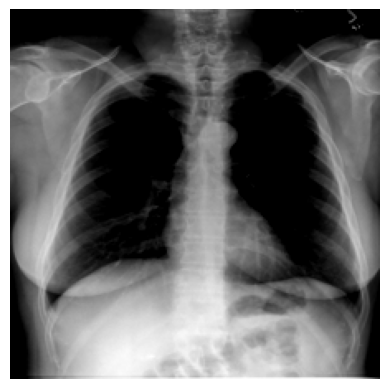

The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 583/583 [03:04<00:00,  3.16it/s]
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


The BLEU Score Is: 0.7058148980314454
Model parameters saved to: loaded_model.h5


/kaggle/working/loaded_model.h5

In [6]:
import matplotlib.pyplot as plt  # Add this import statement
from tqdm import tqdm  # Correct import statement for tqdm

# Display the result
plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)))
plt.show()  # Ensure the image is displayed
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)
print(decoded_out)

# Compute BLEU score
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

predicted_captions = []
for i in tqdm(val_df['imgs']):  # Use tqdm directly
    img = Image.open(i).convert("RGB")
    caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0], skip_special_tokens=True)
    predicted_captions.append(caption)

ground_truth_captions = val_df['captions'].values
ground_truth_captions = [[caption.split() for caption in captions] for captions in ground_truth_captions]
generated_captions = [caption.split() for caption in predicted_captions]

smoothie = SmoothingFunction().method4
weights = (0.25, 0.25, 0.25, 0.25)
score = corpus_bleu(ground_truth_captions, predicted_captions, weights=weights)
print(f'The BLEU Score Is: {score}')

# Save model in .h5 format
import h5py
model_dict = {key: value.cpu().numpy() for key, value in loaded_model.state_dict().items()}
file_path = 'loaded_model.h5'
with h5py.File(file_path, 'w') as hf:
    for key, value in model_dict.items():
        hf.create_dataset(key, data=value)
print(f'Model parameters saved to: {file_path}')

# Create a downloadable link
from IPython.display import FileLink
kaggle_file_path = '/kaggle/working/loaded_model.h5'
FileLink(kaggle_file_path)

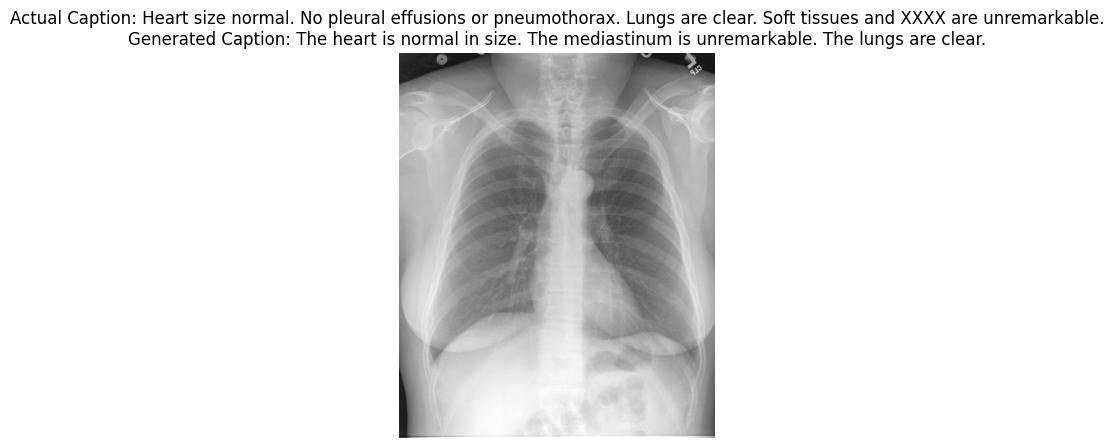

Actual Caption: Heart size normal. No pleural effusions or pneumothorax. Lungs are clear. Soft tissues and XXXX are unremarkable.
Generated Caption: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.


In [7]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Select a single image and its corresponding caption from the validation dataset
sample_index = 43  # You can change this index to test other images
sample_image_path = val_df.iloc[sample_index]['imgs']
actual_caption = val_df.iloc[sample_index]['captions']

# Load the image
img = Image.open(sample_image_path).convert("RGB")

# Generate the caption using the model
with torch.no_grad():
    inputs = feature_extractor(images=img, return_tensors="pt").pixel_values.to("cuda")
    generated_caption_ids = model.generate(inputs, num_beams=4, max_length=512)
    generated_caption = tokenizer.decode(generated_caption_ids[0], skip_special_tokens=True)

# Display the image, actual caption, and generated caption
plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(img)
plt.title(f"Actual Caption: {actual_caption}\nGenerated Caption: {generated_caption}", fontsize=12)
plt.show()

print(f"Actual Caption: {actual_caption}")
print(f"Generated Caption: {generated_caption}")

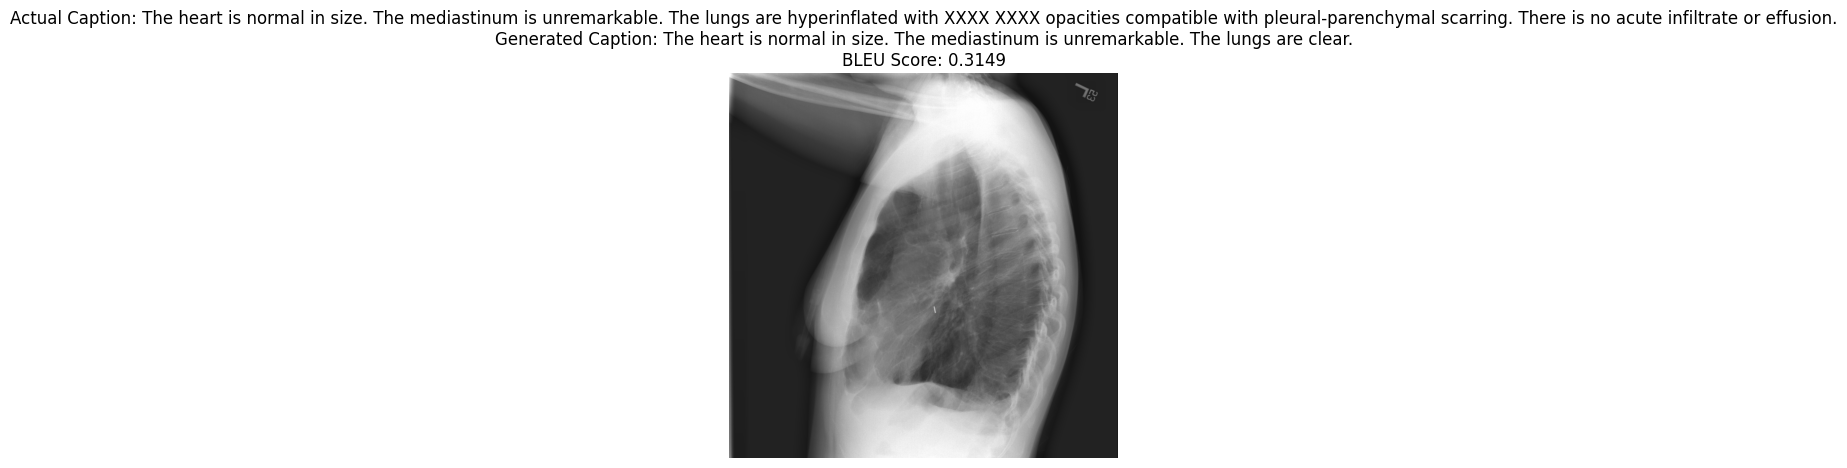

Image Index: 4352
Actual Caption: The heart is normal in size. The mediastinum is unremarkable. The lungs are hyperinflated with XXXX XXXX opacities compatible with pleural-parenchymal scarring. There is no acute infiltrate or effusion.
Generated Caption: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
BLEU Score: 0.3149
--------------------------------------------------------------------------------


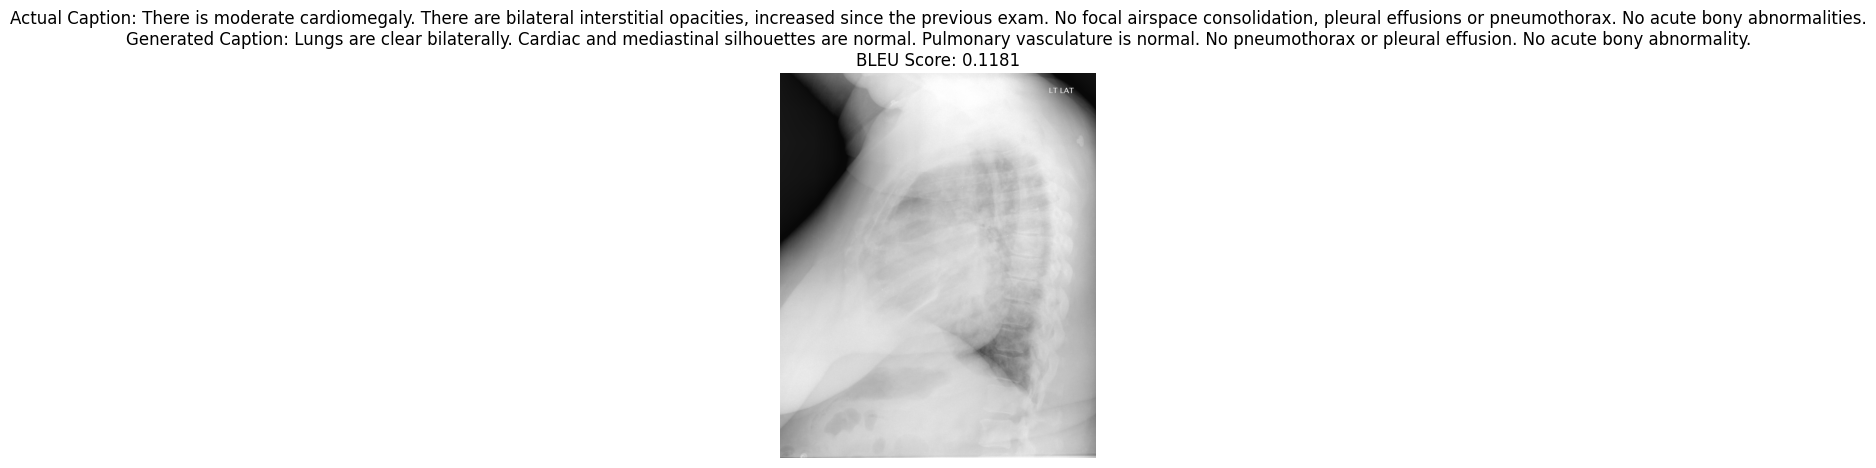

Image Index: 4317
Actual Caption: There is moderate cardiomegaly. There are bilateral interstitial opacities, increased since the previous exam. No focal airspace consolidation, pleural effusions or pneumothorax. No acute bony abnormalities.
Generated Caption: Lungs are clear bilaterally. Cardiac and mediastinal silhouettes are normal. Pulmonary vasculature is normal. No pneumothorax or pleural effusion. No acute bony abnormality.
BLEU Score: 0.1181
--------------------------------------------------------------------------------


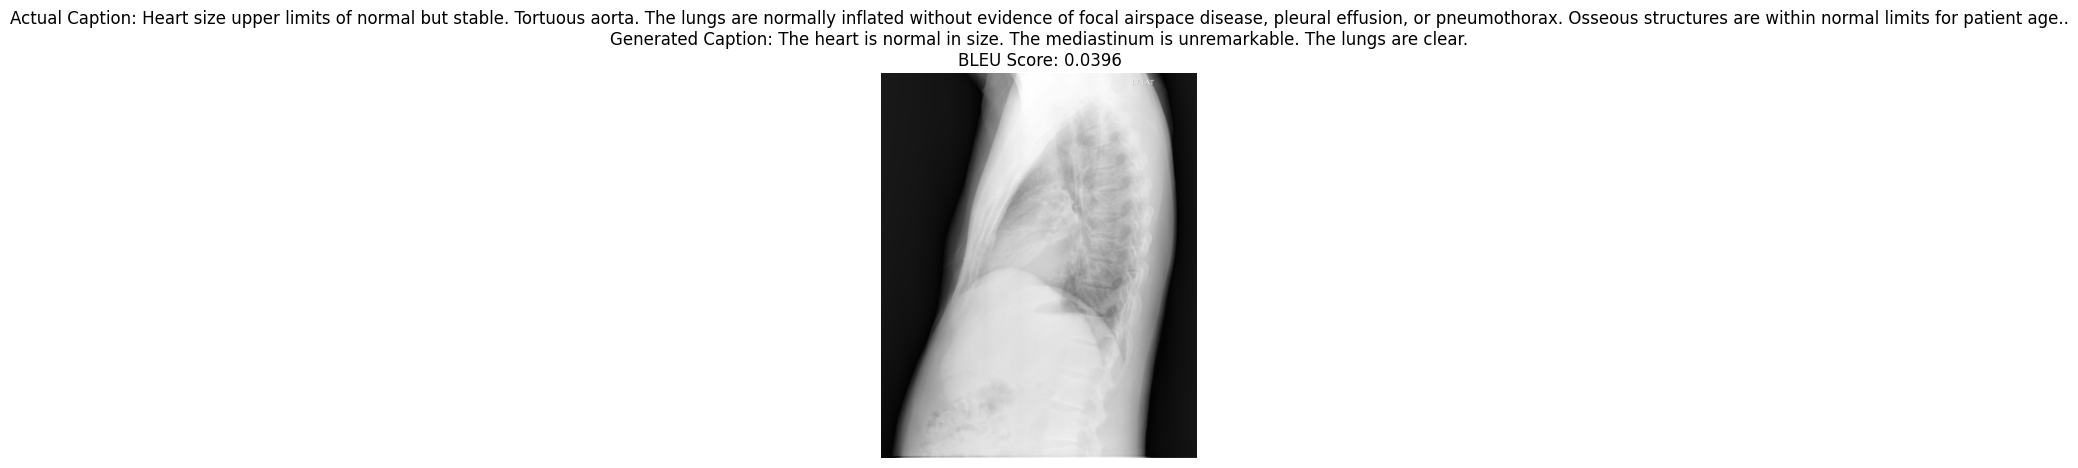

Image Index: 1128
Actual Caption: Heart size upper limits of normal but stable. Tortuous aorta. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Osseous structures are within normal limits for patient age..
Generated Caption: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
BLEU Score: 0.0396
--------------------------------------------------------------------------------


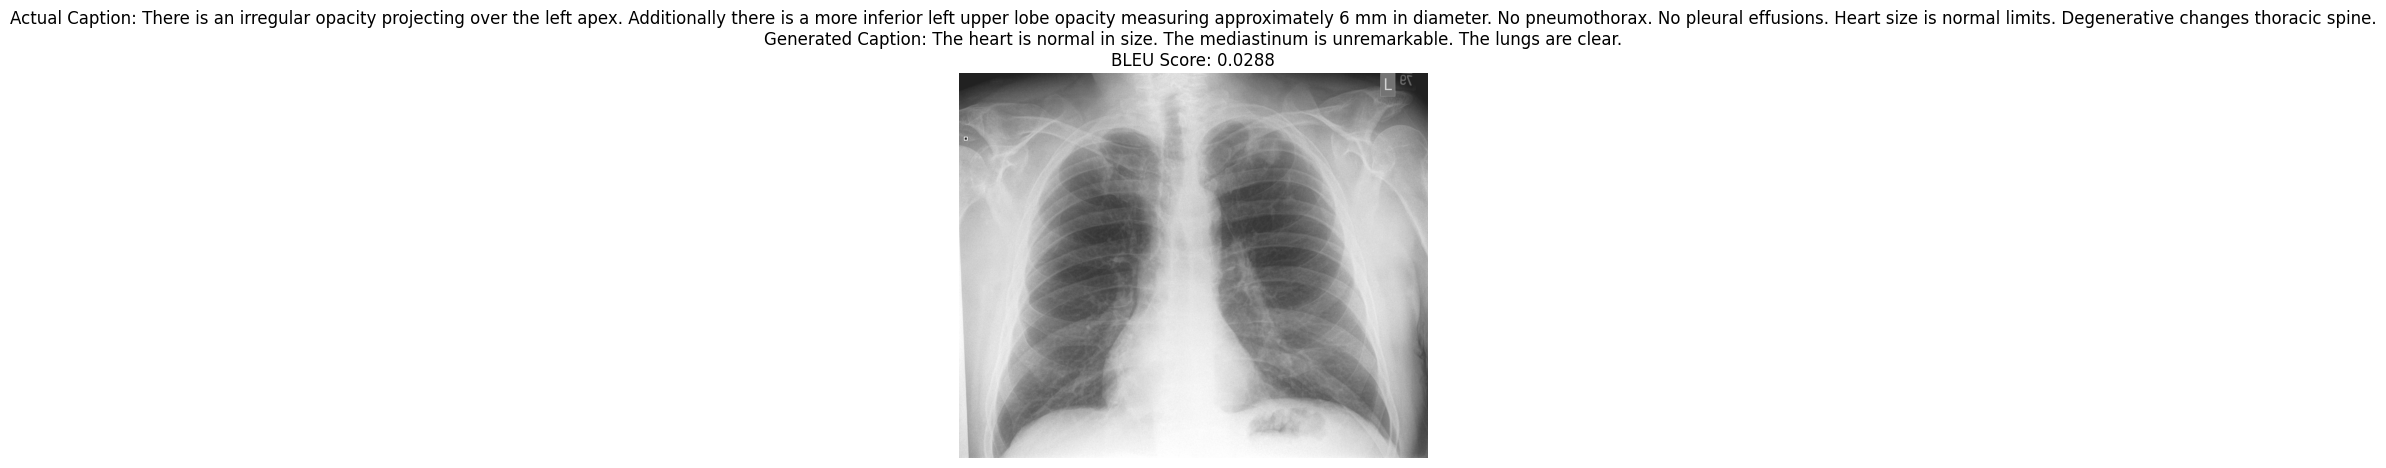

Image Index: 4823
Actual Caption: There is an irregular opacity projecting over the left apex. Additionally there is a more inferior left upper lobe opacity measuring approximately 6 mm in diameter. No pneumothorax. No pleural effusions. Heart size is normal limits. Degenerative changes thoracic spine.
Generated Caption: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
BLEU Score: 0.0288
--------------------------------------------------------------------------------


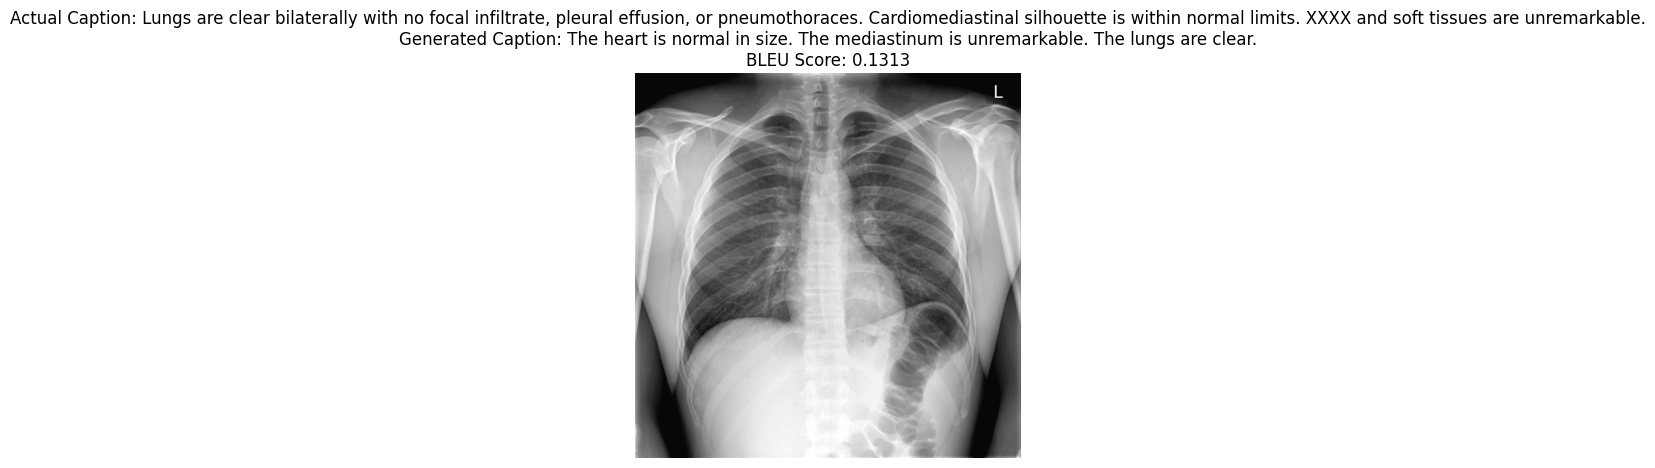

Image Index: 931
Actual Caption: Lungs are clear bilaterally with no focal infiltrate, pleural effusion, or pneumothoraces. Cardiomediastinal silhouette is within normal limits. XXXX and soft tissues are unremarkable.
Generated Caption: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
BLEU Score: 0.1313
--------------------------------------------------------------------------------


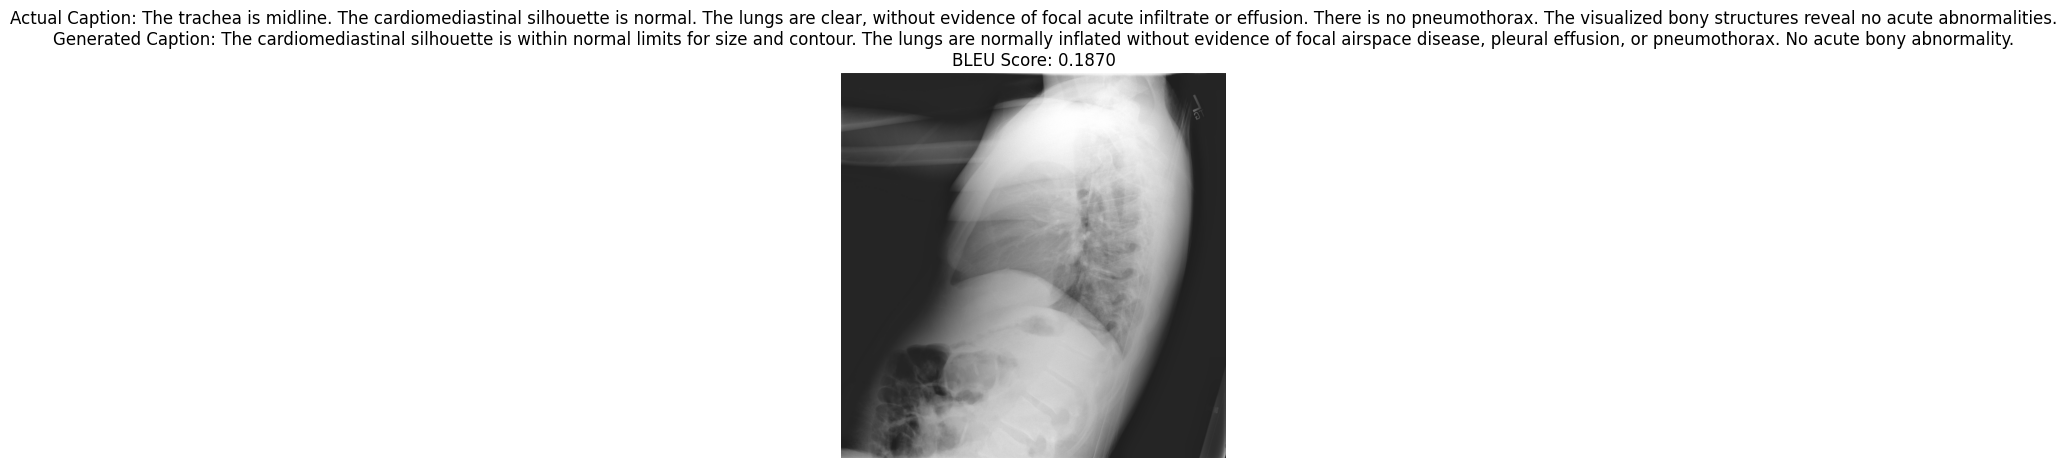

Image Index: 8
Actual Caption: The trachea is midline. The cardiomediastinal silhouette is normal. The lungs are clear, without evidence of focal acute infiltrate or effusion. There is no pneumothorax. The visualized bony structures reveal no acute abnormalities.
Generated Caption: The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. No acute bony abnormality.
BLEU Score: 0.1870
--------------------------------------------------------------------------------


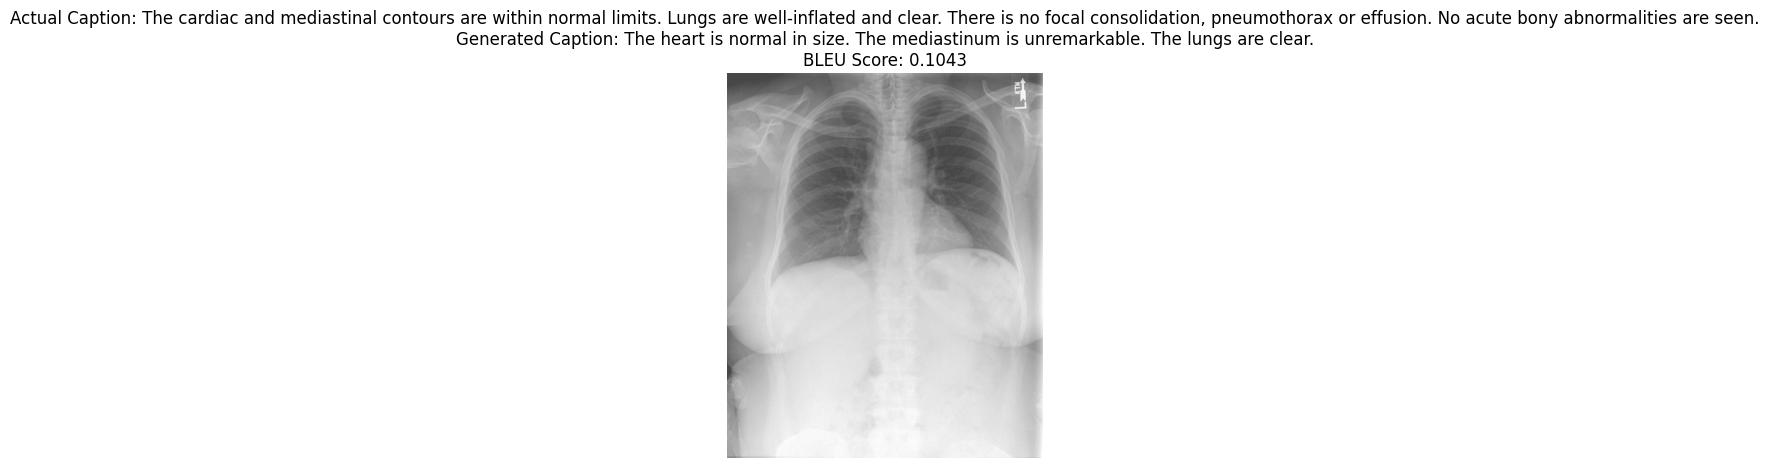

Image Index: 5142
Actual Caption: The cardiac and mediastinal contours are within normal limits. Lungs are well-inflated and clear. There is no focal consolidation, pneumothorax or effusion. No acute bony abnormalities are seen.
Generated Caption: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
BLEU Score: 0.1043
--------------------------------------------------------------------------------


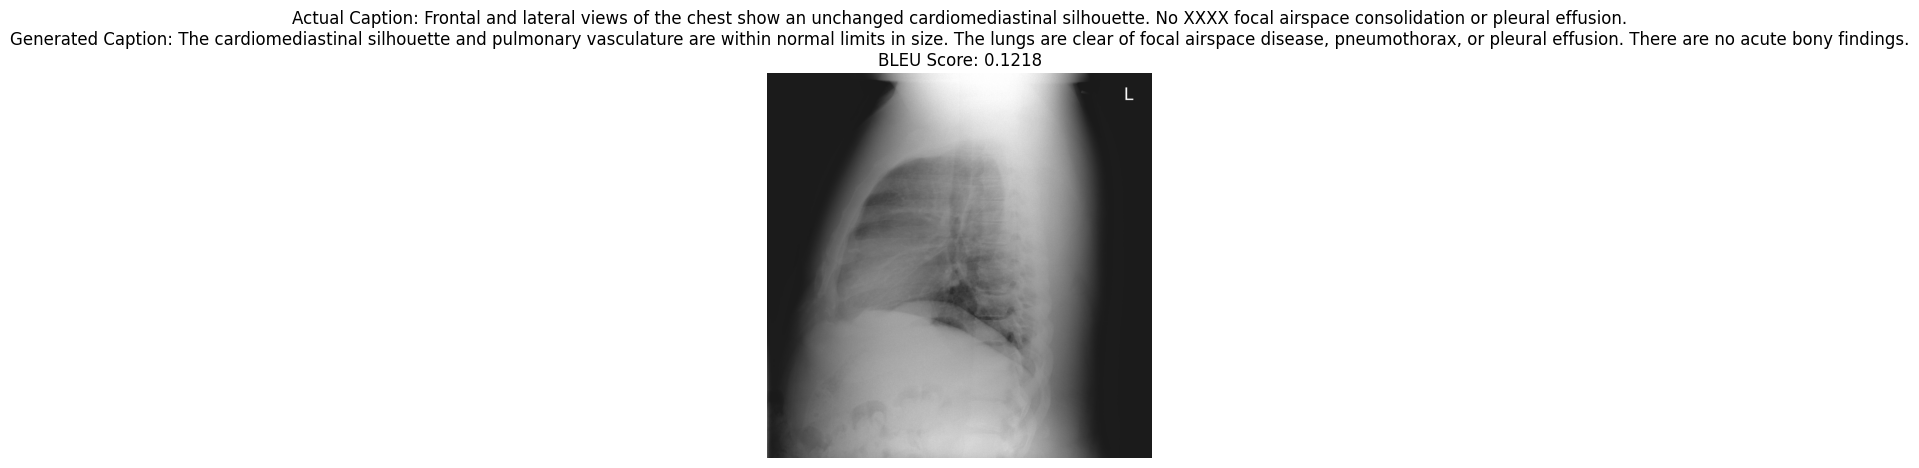

Image Index: 23
Actual Caption: Frontal and lateral views of the chest show an unchanged cardiomediastinal silhouette. No XXXX focal airspace consolidation or pleural effusion.
Generated Caption: The cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. The lungs are clear of focal airspace disease, pneumothorax, or pleural effusion. There are no acute bony findings.
BLEU Score: 0.1218
--------------------------------------------------------------------------------


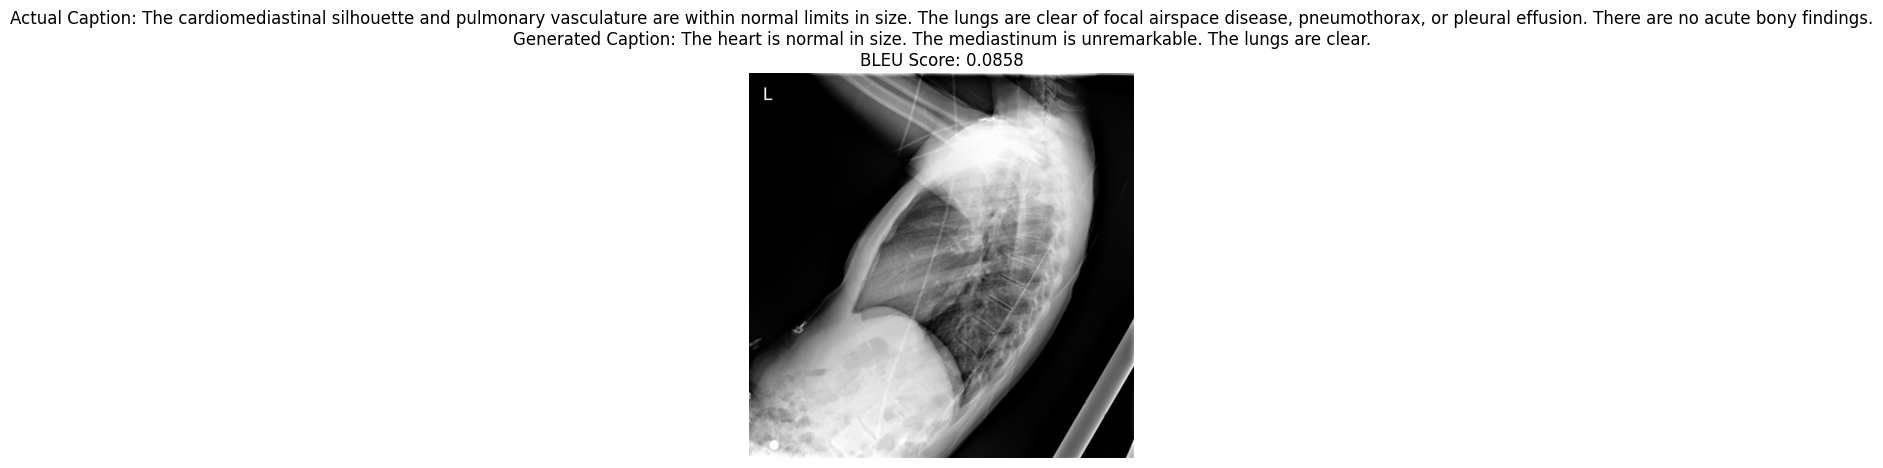

Image Index: 4751
Actual Caption: The cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. The lungs are clear of focal airspace disease, pneumothorax, or pleural effusion. There are no acute bony findings.
Generated Caption: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
BLEU Score: 0.0858
--------------------------------------------------------------------------------


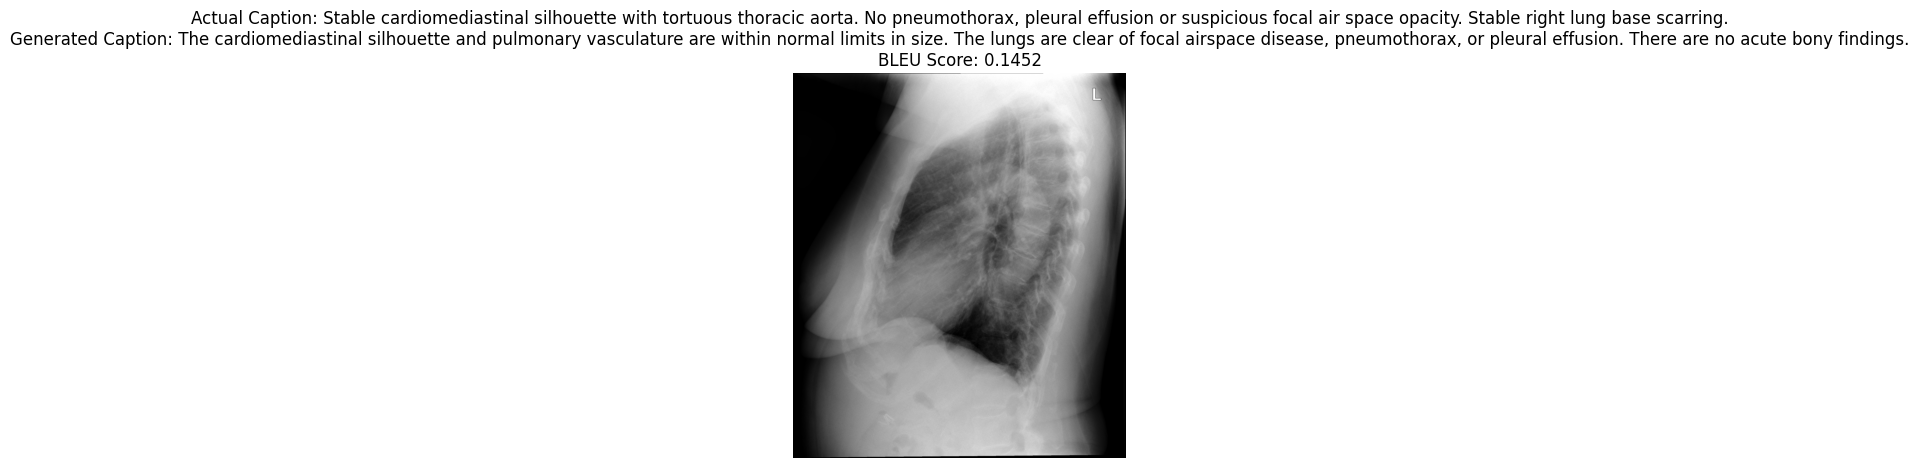

Image Index: 1611
Actual Caption: Stable cardiomediastinal silhouette with tortuous thoracic aorta. No pneumothorax, pleural effusion or suspicious focal air space opacity. Stable right lung base scarring.
Generated Caption: The cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. The lungs are clear of focal airspace disease, pneumothorax, or pleural effusion. There are no acute bony findings.
BLEU Score: 0.1452
--------------------------------------------------------------------------------


In [12]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Function to compute BLEU score
def compute_bleu_score(reference, hypothesis):
    smoothie = SmoothingFunction().method4
    return sentence_bleu([reference.split()], hypothesis.split(), weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

# Reset the DataFrame index to ensure alignment
train_df_reset = train_df.reset_index(drop=True)  # Use train_df instead of val_df

# Select 10 random images from the training dataset
num_images = 10
sample_indices = train_df_reset.sample(n=num_images, random_state=42).index  # Randomly select 10 images

# Iterate over the selected images
for idx in sample_indices:
    # Get the image path and actual caption
    sample_image_path = train_df_reset.iloc[idx]['imgs']
    actual_caption = train_df_reset.iloc[idx]['captions']

    # Load the image
    img = Image.open(sample_image_path).convert("RGB")

    # Generate the caption using the model
    with torch.no_grad():
        inputs = feature_extractor(images=img, return_tensors="pt").pixel_values.to("cuda")
        generated_caption_ids = model.generate(inputs, num_beams=4, max_length=512)
        generated_caption = tokenizer.decode(generated_caption_ids[0], skip_special_tokens=True)

    # Compute BLEU score
    bleu_score = compute_bleu_score(actual_caption, generated_caption)

    # Display the image, actual caption, generated caption, and BLEU score
    plt.figure(figsize=(10, 5))
    plt.axis('off')
    plt.imshow(img)
    plt.title(f"Actual Caption: {actual_caption}\nGenerated Caption: {generated_caption}\nBLEU Score: {bleu_score:.4f}", fontsize=12)
    plt.show()

    # Print the results in the console
    print(f"Image Index: {idx}")
    print(f"Actual Caption: {actual_caption}")
    print(f"Generated Caption: {generated_caption}")
    print(f"BLEU Score: {bleu_score:.4f}")
    print("-" * 80)